In [109]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
np.set_printoptions(legacy='1.25')
import os
import warnings
from functions import *
import ast
warnings.filterwarnings('ignore', category=FutureWarning)

## Poshmark Data Analytics: EDA

This project aims to explore what's selling on Poshmark, sell-through rates for specific products, and the best brands and products to source for resellers on Poshmark. Data was ethically sourced through web-scraping on Poshmark with a script that follows the site's scraping guidlines outlined in the **Robots.txt** file.

The data contains information about sold listings on Poshmark. I chose a few popular categories to scrape and do analyses on instead of selecting from all sold listings on Poshmark, as I wanted to focus on Women's clothing and exclude home and makeup items from the analysis. The categories are: tops, dresses, bags, jeans and skirts.

*For privacy protection, my scraping script is located in a separate directory, and I will remove usernames and the links to specific products from the dataframes before analyses; these columns were used as primary keys to identify unique listings but are not necessary for the data analysis.*

### 1. Opening the Files

In [138]:
tops = pd.read_csv(os.path.expanduser('~/Desktop/data/listings-tops.csv'))
skirts = pd.read_csv(os.path.expanduser('~/Desktop/data/listings-skirts.csv'))
jeans = pd.read_csv(os.path.expanduser('~/Desktop/data/listings-jeans.csv'))
bags = pd.read_csv(os.path.expanduser('~/Desktop/data/listings-bags.csv'))
dresses = pd.read_csv(os.path.expanduser('~/Desktop/data/listings-dresses.csv'))

dfs = [tops, skirts, jeans, bags, dresses]

In [81]:
for df in dfs:
    df.drop(columns = ['link','user'], inplace=True)

In [54]:
tops

,name,sold price,original price,post_date,size,brand,categories,color(s),sold date,nwt,boutique
0,PLUS WASHED SHORT SLEEVE TOP WITH POCKETS 1 XL,$15,NaN,2025-04-26,1X,Zenana Outfitters,"['Women', 'Tops']","['Green', 'Blue']",05-28-2025,0.0,NaN
1,NEW EASEL short sleeve patch front top in yellow,$31,$50,2025-04-18,S,EASEL,"['Women', 'Tops']",['Yellow'],05-28-2025,0.0,NaN
2,Pol NWT white top large 24 ptp,$13,NaN,2025-05-28,00,NaN,"['Women', 'Tops']",[],05-28-2025,1.0,NaN
3,Vuori White Sleeveless Tank Top,$17,$59,2025-05-28,S,Vuori,"['Women', 'Tops']",['White'],05-28-2025,0.0,NaN
4,Pol NWT white top crocheted med,$13,NaN,2025-05-28,M,NaN,"['Women', 'Tops']",[],05-28-2025,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
20303,NEW Tularosa Dara Bodysuit Black Ribbed Turtle...,$22,$95,2024-11-09,S,Tularosa,['tops'],['black'],06-08-2025,0.0,0.0
20304,NIP Black I’d Rather Be Thrifting Graphic Tee,$22,NaN,2025-03-28,L,NaN,['tops'],['black'],06-08-2025,1.0,0.0
20305,NWT FP Movement Ribbed Long Sleeve Logo Baby T...,$58,$58,2025-05-01,L,FP Movement by Free People,['tops'],[],06-08-2025,1.0,0.0
20306,Rails Rosie Top Womens Size M White Cotton Smo...,$32,$192,2025-06-08,M,Rails,['tops'],['white'],06-08-2025,0.0,0.0


### 2. Data Description

Columns:

1. **name**: The name of the listing as it appears on the listing's title.

2. **sold price**: The price the item sold for on Poshmark.

3. **original price**: The price the seller indicated was the original retail price of the item. 
    -- *Limitations:* This information may be inaccurate as it is user-provided, and some listings do not specify an original price.

4. **post_date**: The date the listing was sold to a buyer.

5. **size**: Size of the garmet if applicable.

6. **brand**: Brand of the garmet if applicable.

7. **categories**: Categories of the item.

8. **color(s)**: Colors of the item as outlined in the name. 
    -- *Limitations:* The color is only added to this list if there are mentions of a color in the name.

9. **sold_date**: The inferred sold date of the listing.
    -- *Limitations:* The sold date is inferred based on when the listing was added to the recently sold items page.

10. **nwt**: Whether an item is "New with Tags". 

11. **boutique**: Whether an item was sold from a Boutique, which is a shop that resells clothing sourced from wholesalers rather than used clothing or clothing sourced elsewhere.

In [55]:
tops.columns

Index(['name', 'sold price', 'original price', 'post_date', 'size', 'brand',
       'categories', 'color(s)', 'sold date', 'nwt', 'boutique'],
      dtype='object')

### 3. Data Cleaning

*Cleaning Tasks:*
* Convert numeric columns to correct datatypes.
* Explode the color column for color analyses.
* Convert dates to datetime objects.

In [139]:
for i, df in enumerate(dfs):
    df['sold price'] = df['sold price'].str.replace(',','').str.strip('$').astype('Int64')
    df['original price'] = df['original price'].str.replace(',','').str.strip('$').astype('Int64') 
    df['sold date'] = pd.to_datetime(df['sold date'], format='%m-%d-%Y', errors='coerce')
    df['post_date'] = pd.to_datetime(df['post_date'], format='%Y-%m-%d', errors='coerce')
    # one-hot encoding for colors
    df['color(s)'] = df['color(s)'].str.lower()
    df['color(s)']  = df['color(s)'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    exploded = df.explode('color(s)')
    dummies = pd.get_dummies(exploded['color(s)'])
    ohe_df = dummies.groupby(exploded.index).sum()
    df = df.join(ohe_df)
    dfs[i] = df
tops, skirts, jeans, bags, dresses = dfs

In [140]:
tops

,name,link,sold price,original price,post_date,size,brand,categories,color(s),user,sold date,nwt,boutique,beige,black,blue,bronze,brown,burgundy,butter yellow,charcoal,cream,crimson,fuchsia,gold,gray,green,grey,indigo,lavender,magenta,maroon,mauve,mint,multicolor,navy,orange,peach,pink,plum,purple,rainbow,red,salmon,silver,sky blue,tan,teal,turquoise,violet,white,yellow
0,PLUS WASHED SHORT SLEEVE TOP WITH POCKETS 1 XL,/listing/PLUS-WASHED-SHORT-SLEEVE-TOP-WITH-POC...,15,<NA>,2025-04-26,1X,Zenana Outfitters,"['Women', 'Tops']","[green, blue]",cloudsmoonsun,2025-05-28,0.0,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,NEW EASEL short sleeve patch front top in yellow,/listing/NEW-EASEL-short-sleeve-patch-front-to...,31,50,2025-04-18,S,EASEL,"['Women', 'Tops']",[yellow],nwtbrands2love2,2025-05-28,0.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,Pol NWT white top large 24 ptp,/listing/Pol-NWT-white-top-large-24-ptp-6837a3...,13,<NA>,2025-05-28,00,NaN,"['Women', 'Tops']",[],boutique10,2025-05-28,1.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Vuori White Sleeveless Tank Top,/listing/Vuori-White-Sleeveless-Tank-Top-6837a...,17,59,2025-05-28,S,Vuori,"['Women', 'Tops']",[white],stephinlaguna,2025-05-28,0.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,Pol NWT white top crocheted med,/listing/Pol-NWT-white-top-crocheted-med-6837a...,13,<NA>,2025-05-28,M,NaN,"['Women', 'Tops']",[],boutique10,2025-05-28,1.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20303,NEW Tularosa Dara Bodysuit Black Ribbed Turtle...,/listing/NEW-Tularosa-Dara-Bodysuit-Black-Ribb...,22,95,2024-11-09,S,Tularosa,['tops'],[black],ftlod,2025-06-08,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20304,NIP Black I’d Rather Be Thrifting Graphic Tee,/listing/NIP-Black-Id-Rather-Be-Thrifting-Grap...,22,<NA>,2025-03-28,L,NaN,['tops'],[black],_dresswithness_,2025-06-08,1.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20305,NWT FP Movement Ribbed Long Sleeve Logo Baby T...,/listing/NWT-FP-Movement-Ribbed-Long-Sleeve-Lo...,58,58,2025-05-01,L,FP Movement by Free People,['tops'],[],atonsing16,2025-06-08,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20306,Rails Rosie Top Womens Size M White Cotton Smo...,/listing/Rails-Rosie-Top-Womens-Size-M-White-C...,32,192,2025-06-08,M,Rails,['tops'],[white],nw_threads22,2025-06-08,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## 4. Top Performing Brands

Identifying the top-performing brands based on popularity.

In [8]:
# top 10 brands by number of sold listings
top_brands = tops['brand'].value_counts().head(15).index
popular_brand_df = tops[tops['brand'].isin(top_brands)]

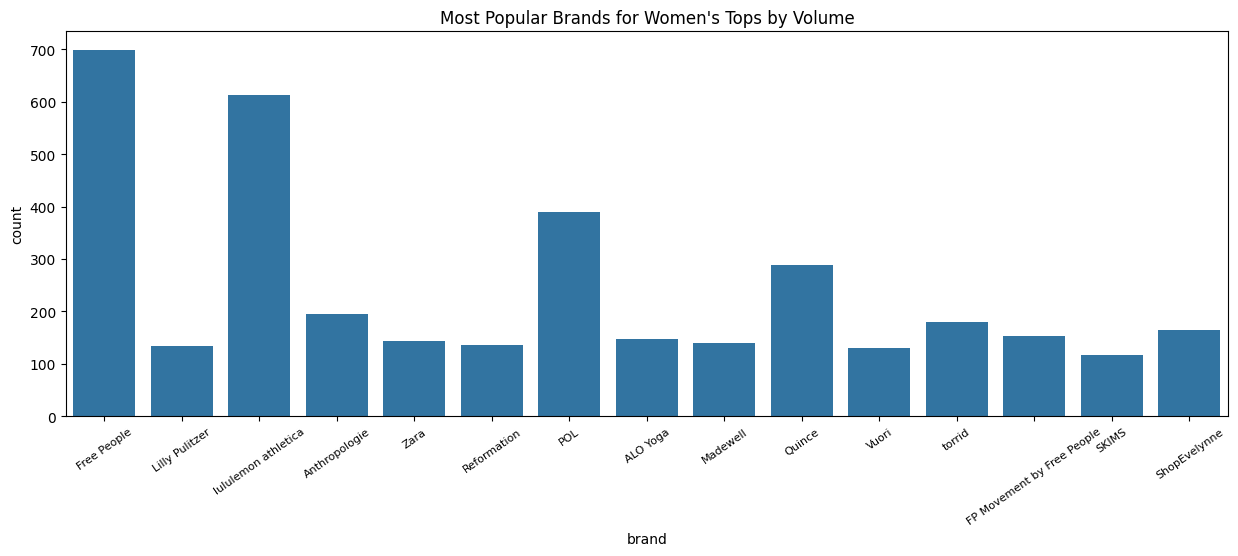

In [10]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=35, fontsize=8)
plt.title("Most Popular Brands for Women's Tops by Volume")

ax = sns.countplot(data=popular_brand_df, x='brand')

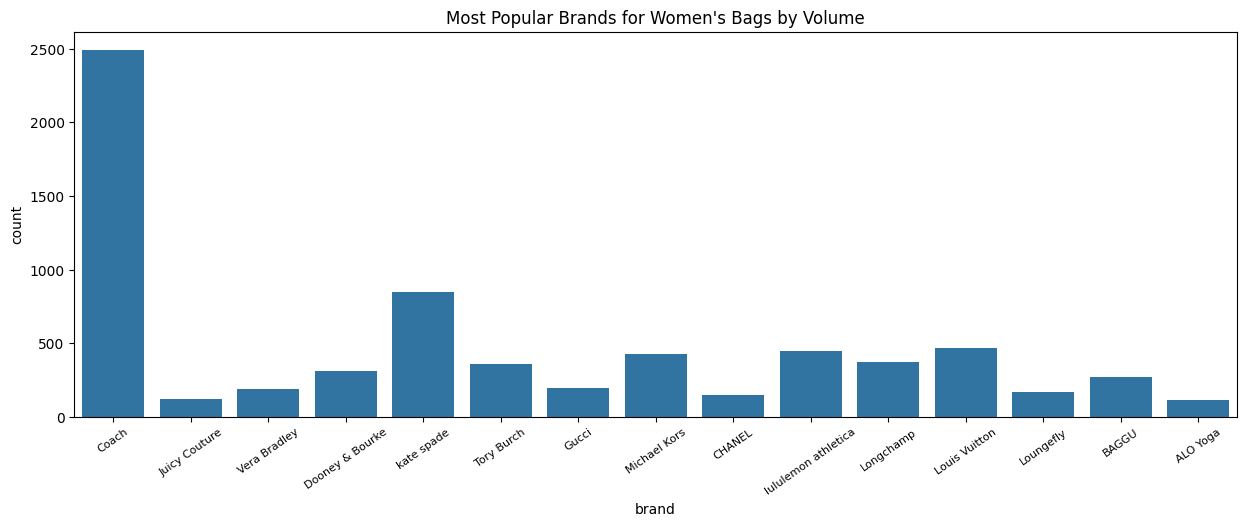

In [11]:
# top 10 brands by number of sold listings
top_brands_bags = bags['brand'].value_counts().head(15).index
popular_brand_bags_df = bags[bags['brand'].isin(top_brands_bags)]

plt.figure(figsize=(15,5))
plt.xticks(rotation=35, fontsize=8)
plt.title("Most Popular Brands for Women's Bags by Volume")

ax = sns.countplot(data=popular_brand_bags_df, x='brand')

### 5. Brands with Quickest Sell-through Rate

Identifying the brands that sell the fastest, on average.

In [12]:
tops['days to sell'] = (tops['sold date'] - tops['post_date']).dt.days

In [13]:
def avg_days_to_sell_by_brand(df, num_brands, min_sales, category):    
    
    brand_counts = df['brand'].value_counts()
    brands_over_min_sales = brand_counts[brand_counts > min_sales].index

    tops_filtered = tops[tops['brand'].isin(brands_over_min_sales)].sort_values(by='days to sell', ascending=True)

    fastest_brands = tops_filtered.groupby('brand')['days to sell'].agg('mean').sort_values(ascending=True).reset_index()

    top_fastest = fastest_brands[:num_brands]

    plt.figure(figsize=(15, 6))
    sns.barplot(data=top_fastest, x='days to sell', y='brand', palette='viridis')

    plt.title(f"Top {num_brands} Brands with Lowest Average Days to Sell in Women's {category} (Brands with >{min_sales} Listings)")
    plt.xlabel('Average Days to Sell')
    plt.xticks(fontsize=9)
    plt.ylabel('Brand')

    plt.tight_layout()
    plt.show()


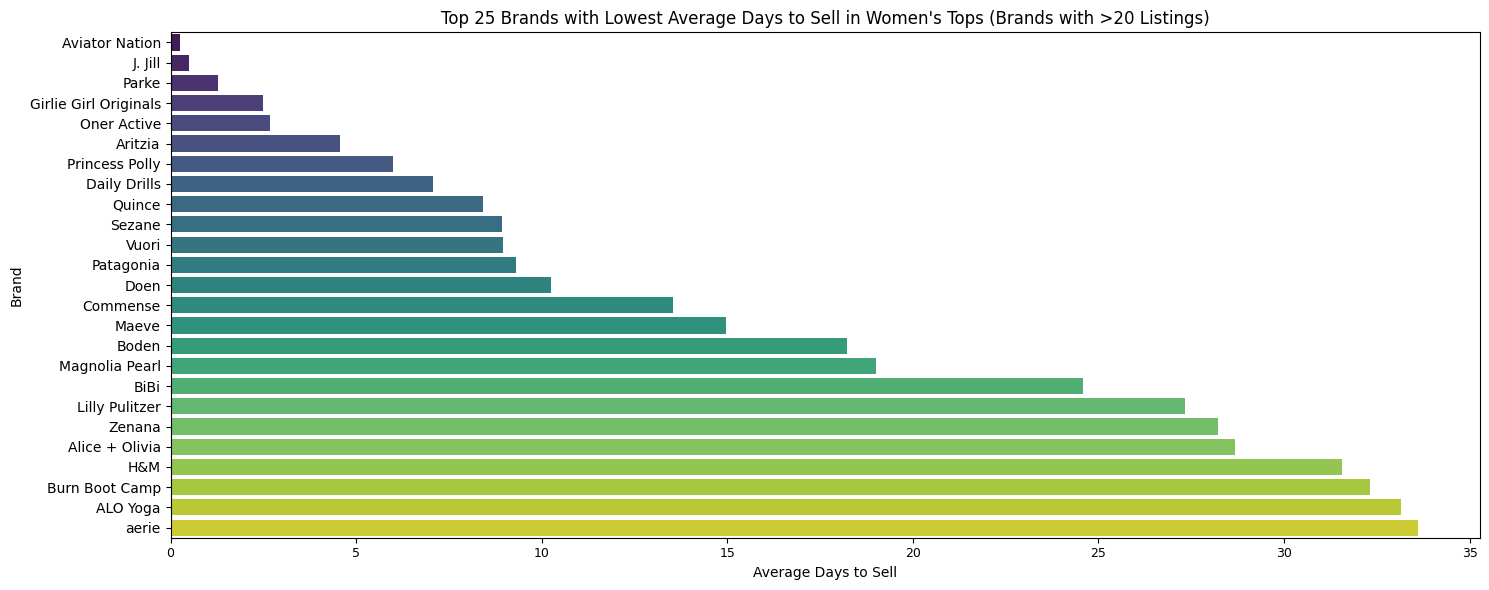

In [14]:
avg_days_to_sell_by_brand(tops, 25, 20, 'Tops')

#### *Removing Outliers*

Some top-selling brands, such as *Free People* and *lululemon*, is not included in the quickest days to sell. There may be some extreme outliers in the 'days to sell' column, which should be removed for a better visualization.

Text(0.5, 1.0, 'Days to sell Free People tops')

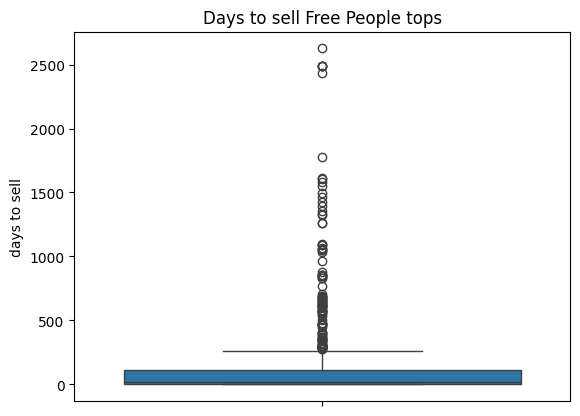

In [15]:
# visualizing the outliers for Free People
sns.boxplot(tops[tops['brand'] == 'Free People']['days to sell'])
plt.title("Days to sell Free People tops")

Based on the boxplot, the tail of outliers going into the 1000+ days to sell range may be weighing down the average.

Text(0.5, 1.0, 'Days to sell Free People tops, outliers removed')

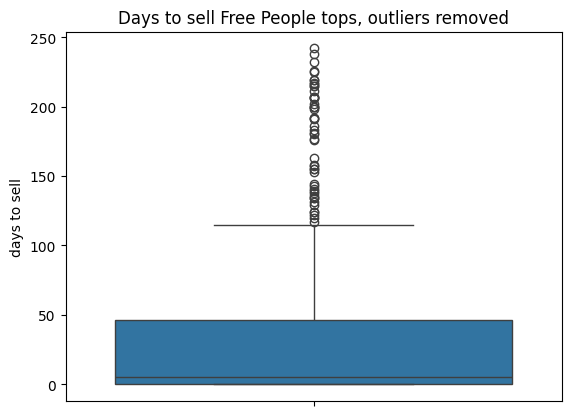

In [16]:
filtered_tops = remove_outliers_iqr(tops, 'days to sell')
sns.boxplot(filtered_tops[filtered_tops["brand"]=="Free People"]["days to sell"])
plt.title('Days to sell Free People tops, outliers removed')

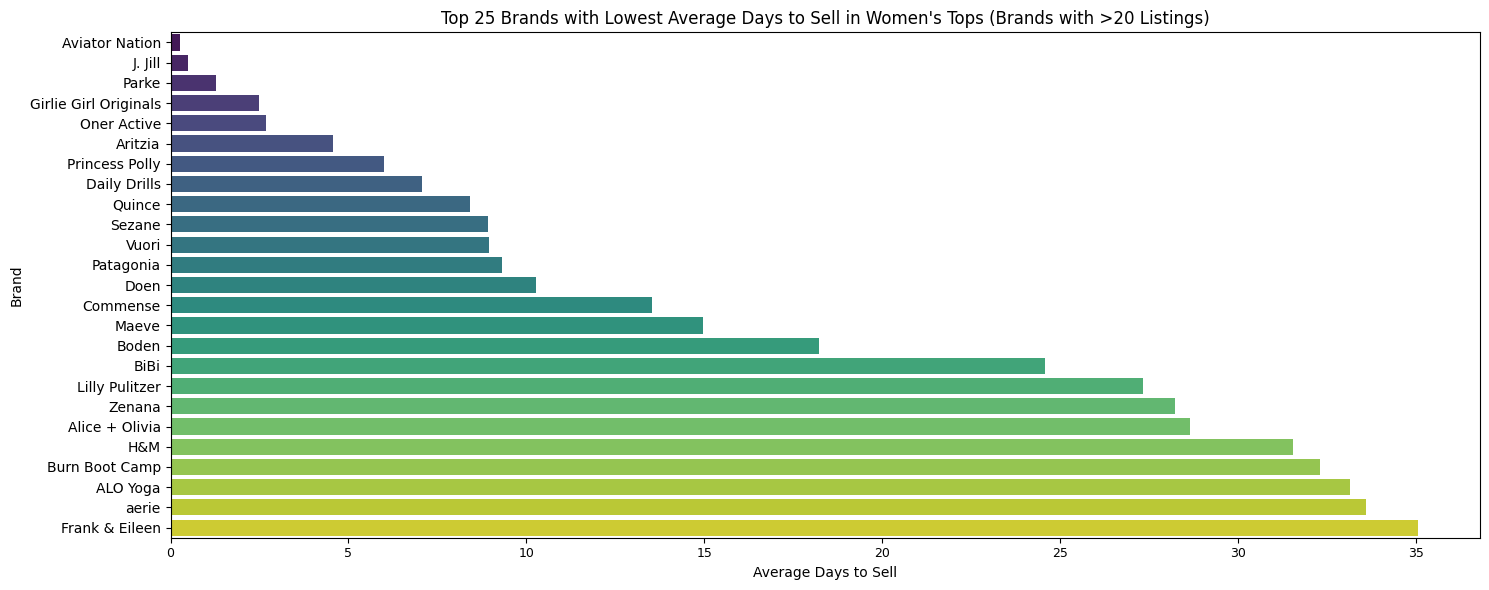

In [18]:
avg_days_to_sell_by_brand(filtered_tops, 25, 20, 'Tops')

Removing outliers via IQR did not add *Free People* to the top-selling brands, indicating *Free People* is a popularly purchased brand, but it takes longer to sell compared to other popular brands. This could be important for someone sourcing inventory for their shop, as prioritizing quick-to-sell brands may align more with their shop goals.

It also could be due brands with fewer rows taking over; next I will visualize by only including brands with more than 100 listings in the dataset.

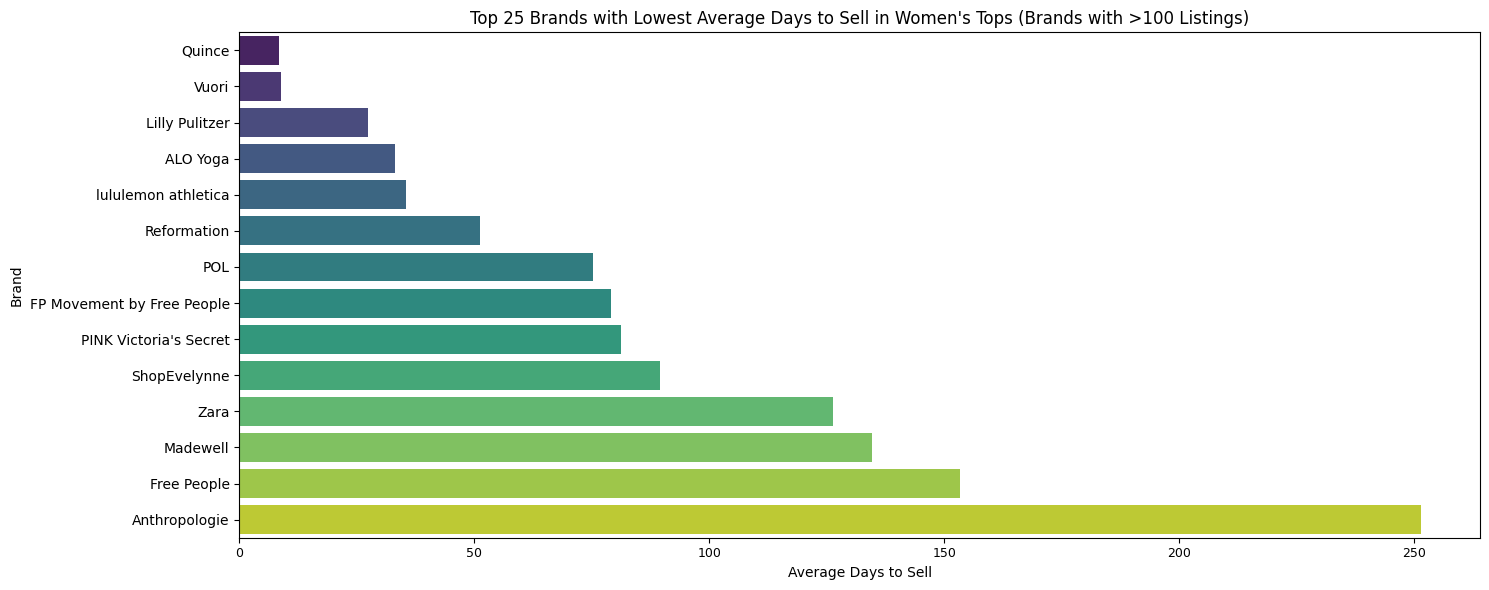

In [19]:
avg_days_to_sell_by_brand(filtered_tops, 25, 100, 'Tops')

There are only 14 brands with over 100 listings in the dataset, and *Free People* is still the second lowest to sell even after outliers were removed.

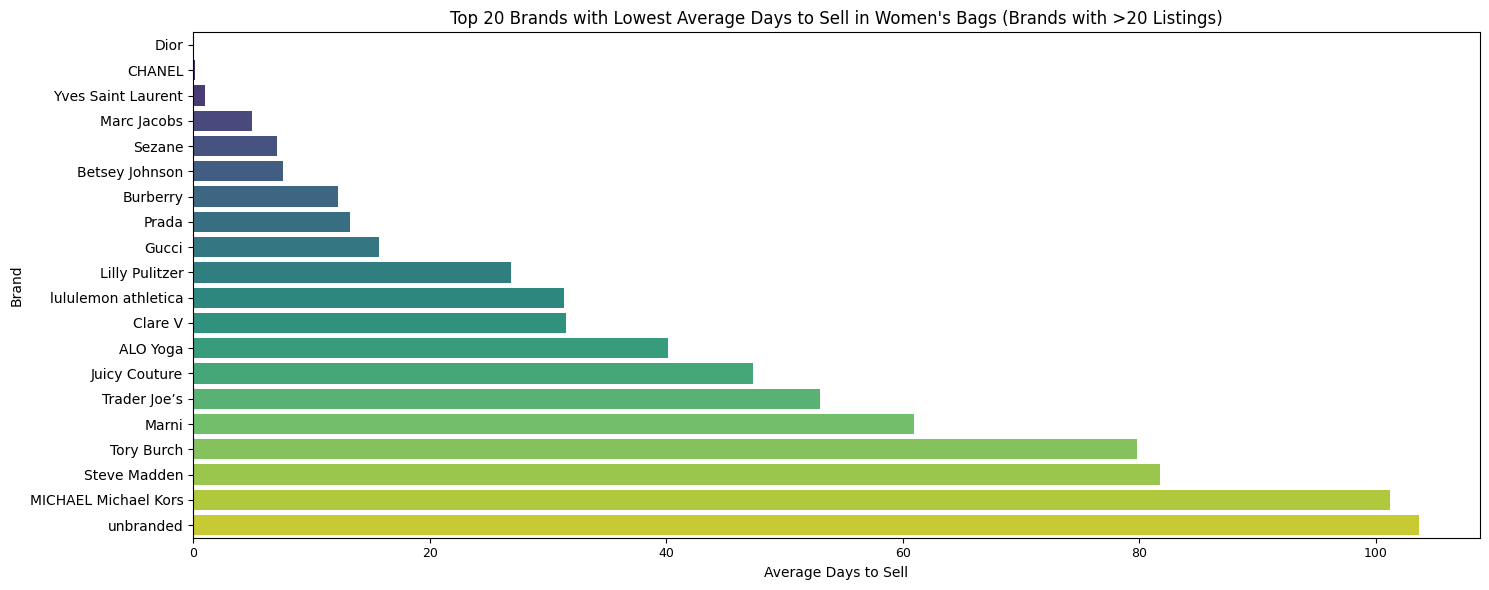

In [145]:
avg_days_to_sell_by_brand(bags, 20, 20, 'Bags')

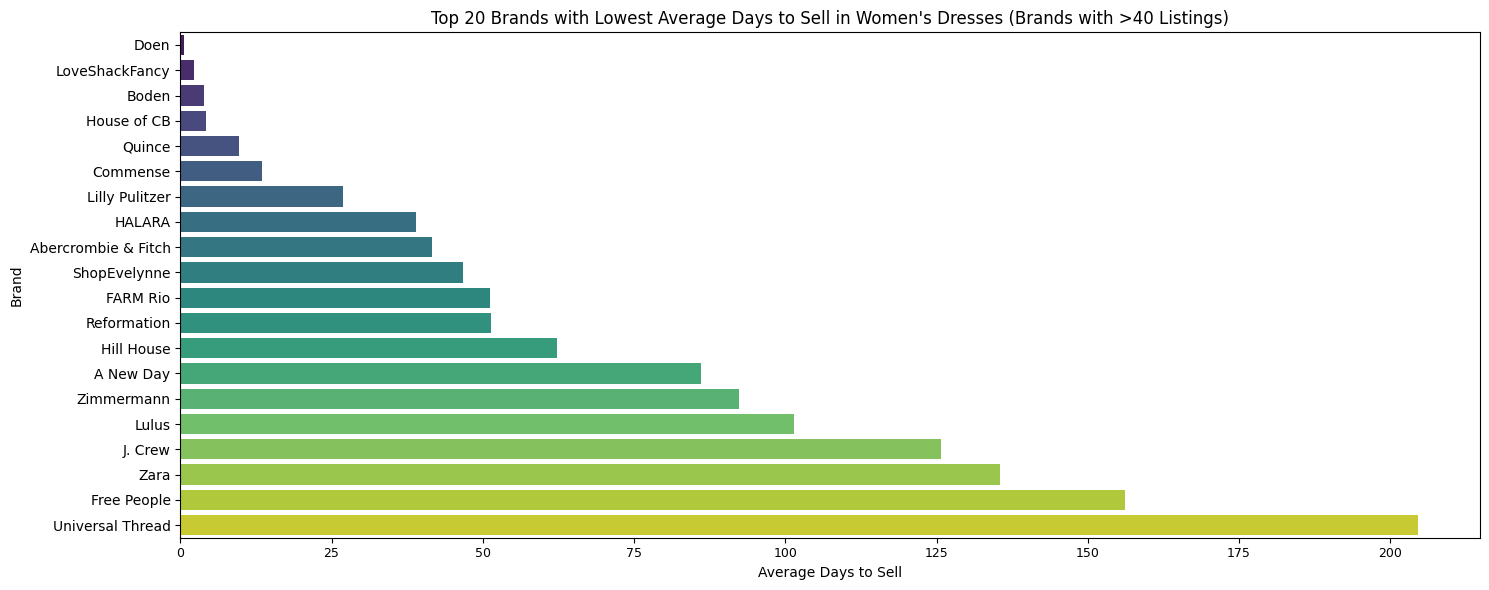

In [147]:
avg_days_to_sell_by_brand(dresses, 20, 40, 'Dresses')

### 6. Most Popular Sizes

In [20]:
size_counts = tops['size'].value_counts()[:10]
top_10_sizes = tops[tops['size'].isin(size_counts.index)]

<Axes: xlabel='size'>

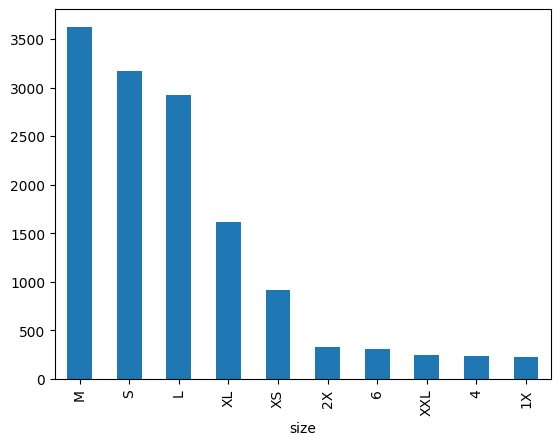

In [21]:
size_counts.plot(kind='bar')

In [22]:
top_10_sizes.groupby(by='size')['sold price'].agg('mean').sort_values(ascending=False)

size
4      48.728448
6       42.48366
S      39.394197
XS      37.82879
M      33.636614
L      31.244626
2X     29.437126
1X      28.36036
XL     26.529084
XXL    24.345679
Name: sold price, dtype: Float64

### 7. Average Prices by Brand

In [24]:
tops.groupby('brand')['sold price'].agg('mean')

brand
-BL^NK-                  118.0
.                    89.857143
1. State                  20.0
11 Honore                 26.0
120% Lino                 75.0
                       ...    
xenana outfitters         10.0
xoxoklowe                 64.0
yllw                      85.0
zaddy                     50.0
zeela                      5.0
Name: sold price, Length: 2206, dtype: Float64

In [26]:
# tops with at least 20 sales in the dataset
tops_at_least_20 = tops[tops['brand'].isin(tops['brand'].value_counts().head(20).index)]

In [31]:
tops_sold_price_by_brand = tops_at_least_20.groupby('brand')[['sold price', 'original price']].agg('mean')

In [34]:
tops_sold_price_by_brand.sort_values(by='sold price', ascending=False)

,sold price,original price
brand,,
Reformation,75.411765,146.169355
POL,67.141388,181.710145
ShopEvelynne,50.666667,82.018182
FP Movement by Free People,46.896104,71.410072
Free People,42.586552,174.009579
SKIMS,42.418803,77.324675
ALO Yoga,38.709459,94.141509
Vuori,35.083969,70.10101
Lilly Pulitzer,34.634328,115.522222
